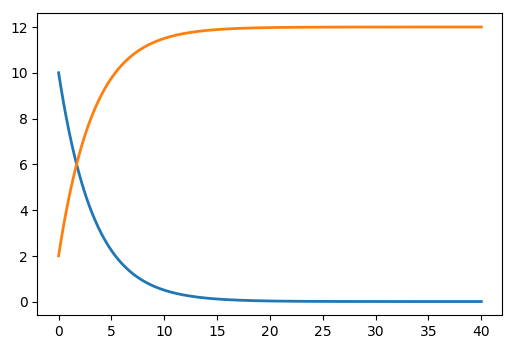

In [6]:
%matplotlib inline
import tellurium as te

rr = te.loada('''
    model example0
    # A comment
      S1 -> S2; k1*S1
      S1 = 10
      S2 = 2
      k1 = k2
      k2 = 0.3
    end
''')

result = rr.simulate(0, 40, 500) 
te.plotArray(result)

Model assumptions:
1. Ln, LTn have the same kinetic constants for dephosphorylation
2. Start with all T as T2
3. Estimated k1a, k1b
4. Dephosphorylation occurs at the same rate for bound and unbound receptors
5. The system begins with all Tar in state T2 (doubly methylated)
6. Demethylation of Yp does not consider Z (as per Spiro).
7. k1a is estimated based on the rates for k_on for the bimolecular reaction L + T -> LT, k_on = k5 = 7*10e7.
   We use the constant ktuning to adjust the fraction of k5 that's used

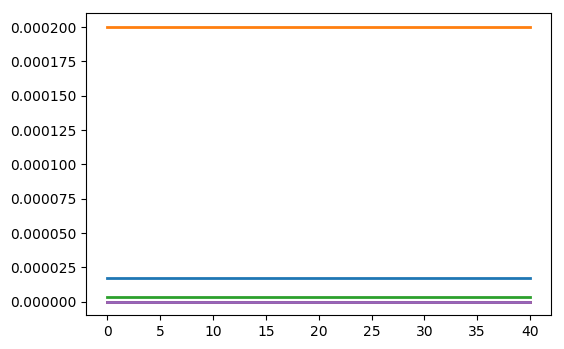

In [8]:
%matplotlib inline
import tellurium as te

rr = te.loada('''
    # This model is from Spiral et al., PNAS, 1997
    model chemotaxis
      # REACTIONS from Table 3
      # Methylation
      T2R -> T3 + R; k1c*T2R
      T3R -> T4 + R; k2c*T3R
      LT2R -> LT3 + R; k3c*LT2R
      LT3R -> LT4 + R; k4c*LT3R
      #   Details of Tn + R <-> TnR
      T2R -> T2 + R; k1a*T2R
      T2 + R -> T2R; k1b*T2*R
      T3R -> T3 + R; k2a*T3R
      T3 + R -> T3R; k2b*T3*R
      T4R -> T4 + R; k3a*T4R
      T4 + R -> T4R; k3b*T4*R
      # Demethylation reactions
      T3 + Bp -> T2 + Bp; k_1*T3*Bp
      T4 + Bp -> T3 + Bp; k_2*T4*Bp  
      LT3 + Bp -> LT2 + Bp; k_3*T3*Bp
      LT4 + Bp -> LT3 + Bp; k_4*T4*Bp
      # Ligand binding gives details to L + T -> LT, LT -> L + T
      L + T2 -> LT2; k5*T2*L
      L + T3 -> LT3; k5*T3*L
      L + T4 -> LT4; k5*T4*L
      LT2 -> T2 + L; k_5*LT2
      LT3 -> T3 + L; k_5*LT3
      LT4 -> T4 + L; k_5*LT4
      # Autophosphorylation reactions
      T2 -> T2p; k8*T2
      T3 -> T3p; k9*T2
      T4 -> T4p; k10*T2
      LT2 -> LT2p; k11*LT2
      LT3 -> LT3p; k12*LT3
      LT4 -> LT4p; k13*LT4
      # B phosphorylations
      T2p + B -> T2 + Bp; kb*T2p*B
      T3p + B -> T3 + Bp; kb*T3p*B
      T4p + B -> T4 + Bp; kb*T4p*B
      LT2p + B -> LT2 + Bp; kb*LT2p*B
      LT3p + B -> LT3 + Bp; kb*LT3p*B
      LT4p + B -> LT4 + Bp; kb*LT4p*B
      # Y phosphorylations
      T2p + Y -> T2 + Yp; ky*T2p*Y
      T3p + Y -> T3 + Yp; ky*T3p*Y
      T4p + Y -> T4 + Yp; ky*T4p*Y
      TL2p + Y -> LT2 + Yp; ky*LT2p*Y
      LT3p + Y -> LT3 + Yp; ky*LT3p*Y
      LT4p + Y -> LT4 + Yp; ky*LT4p*Y
      # B & Y dephosphorylations
      Bp -> B; k_b*Bp
      Yp + Z -> Y + Z; k_y*Yp*Z    
      # CONSTANTS from Table 3, except k1a (which is noted above).
      k1a = 10*10e6
      ktuning = 0.9
      k1b = ktuning*k5
      k2a = k1a
      k2b = k1b
      k3a = k1a
      k3b = k1b
      k1c = 0.17
      k2c = 0.1*k1c
      k3c = 30*k2c
      k4c = k3c
      k5  = 7*10e7
      k_5 = 70
      k_1 = 4*10e5
      k_2 = 3*10e4
      k_3 = k_1
      k_4 = k_2
      k8 = 15
      k9 = 3*k8
      k10 = 3.2*k8
      k11 = 0
      k12 = 1.1*k8
      k13 = 0.72*k10
      kb = 8*10e5
      ky = 3*10e7
      k_b = 0.35
      k_y = 5*10e5
      # INITIAL VALUES from Table 2
      T2 = 8*10e-6
      R = 0.3*10e-6
      B = 1.7*10e-6
      Y = 20*10e-6
      T2R = 0
      T3R = 0
      LT2R = 0
      LT3R = 0
      L = 0
      T2 = 0
      T3 = 0
      T4 = 0
      LT2 = 0
      LT3 = 0
      LT4 = 0
      T2p = 0
      T3p = 0
      T4p = 0
      LT2p = 0
      LT3p = 0
      LT4p = 0
      Yp = 0
      Bp = 0
    end
''')

result = rr.simulate(0, 40, 500) 
te.plotArray(result)